# Loop Modeling
Keywords: loops, fold_tree_from_loops, CCD, KIC, cut-point variant, FoldTree, MoveMap

Loop modeling is an important step in building homology models, designing enzymes, or docking with flexible loops. In this notebook, you'll learn how to manually set up a loop FoldTree to gain an understanding of how it works. However, in practice, you will not need to make the FoldTree from scratch, and we will see examples of this is the next notebook.


## Suggested Readings

* A. Canutescu & R. L. Dunbrack, “Cyclic coordinate descent: A robotics algorithm for protein loop closure,” Protein Sci. 12, 963-972 (2003).

* Wang, P. Bradley & D. Baker, “Protein-protein docking with backbone flexibility,” J. Mol. Biol. 373, 503-519 (2007).

* J. Mandell,  E. A. Coutsias & T. Kortemme, “Sub-angstrom accuracy in protein loop reconstruction by robotics-inspired conformational sampling,” Nature Meth. 6, 551-552 (2009).

In [2]:
# Notebook setup
import sys
if 'google.colab' in sys.modules:
    !pip install pyrosettacolabsetup
    import pyrosettacolabsetup
    pyrosettacolabsetup.setup()
    print ("Notebook is set for PyRosetta use in Colab.  Have fun!")

In [39]:
from pyrosetta import *
from pyrosetta.rosetta import *
from pyrosetta.teaching import *

from rosetta.core.kinematics import FoldTree
pyrosetta.init()

core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python36.mac r208 2019.04+release.fd666910a5e fd666910a5edac957383b32b3b4c9d10020f34c1 http://www.pyrosetta.org 2019-01-22T15:55:37
core.init: command: PyRosetta -ex1 -ex2aro -database /Users/kathyle/Computational Protein Prediction and Design/PyRosetta4.Release.python36.mac.release-208/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=-128678703 seed_offset=0 real_seed=-128678703
core.init.random: RandomGenerator:init: Normal mode, seed=-128678703 RG_type=mt19937


## Fold Tree
Because we typically want to isolate the conformational changes to the loop region, we need a framework to hold the rest of the protein together. This is accomplished — as was the case with protein-protein docking — with a fold tree, which is a graph that dictates the propagation of conformational changes throughout the Pose.

For the following exercises, you can find the working PDB, `test_in.pdb`, and a 3mer fragment file, `test_in.frag3` in the `inputs` folder.

**Make sure you are in the directory with the pdb files:**

`cd google_drive/My\ Drive/student-notebooks/`

In [1]:
#cd google_drive/My\ Drive/student-notebooks/

### Fold Tree (from scratch)

Load the `test_in.pdb` structure (116 residues).
```
start_pose = pyrosetta.pose_from_file("inputs/test_in.pdb")
```

In [63]:
start_pose = pyrosetta.pose_from_file("inputs/test_in.pdb")
pose.assign(start_pose)

core.import_pose.import_pose: File 'inputs/test_in.pdb' automatically determined to be of type PDB


We want to operate on the first loop, residues 15–24. For the fold tree, we place the jump anchors two residues outside of the loop range, i.e., residues 13–26. In loop modeling, the jump points are set at i-2 and j+2, where i and j are the beginning and end residues of the loop, respectively.

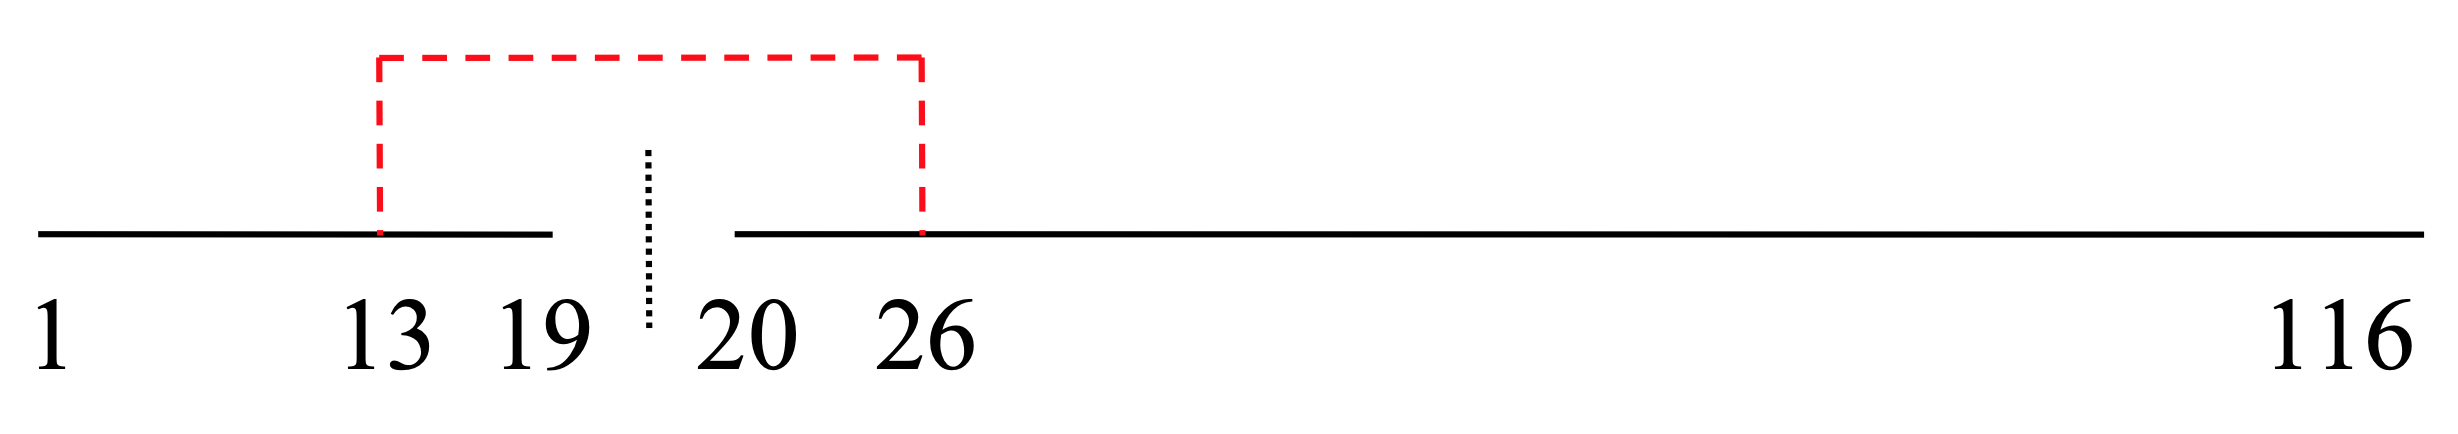

In [41]:
from IPython.display import Image
Image('./Media/fold-tree1.png',width='700')

That is, we want a cut between residues 19 and 20, to allow motions in the loop that do not propagate through the rest of the protein. To tie the pieces together, we use a jump between residues 13 and 26. These residues will stay connected to each other.

To make such a tree in PyRosetta, first we create a `FoldTree` object:

```
ft = FoldTree()
```

In [64]:
ft = FoldTree()

__Be careful that you don't re-run the same cell multiple times as you will keep adding these pieces to the FoldTree, which will mess it up__

Then we add the "edges” and the jump. Both `EDGE`s and `Jump`s are entered using the `FoldTree`’s `add_edge(start, end, code)` command, with peptide edges coded with a “-1” and jumps enumerated with the positive integers. (The first jump is coded “1”, the second “2”, etc.) The first edge is from residues 1 to 13:

```
ft.add_edge(1, 13, -1)
```

In [65]:
ft.add_edge(1, 13, -1)

Then the second is from 13 to 19. __An `EDGE` must always start from a residue that has already been defined in another `EDGE`__, thus we use 13 here and not 14. (The one exception is the first edge, which starts from the graph’s “root”).

```
ft.add_edge(13, 19, -1)
```

In [66]:
ft.add_edge(13, 19, -1)

Next, the `Jump`, which is specified with the integer code 1, tells Rosetta that this is a rigid-body connection, not a peptide `EDGE`:

```
ft.add_edge(13, 26, 1)
```

In [67]:
ft.add_edge(13, 26, 1)

Finally, we add the last two `EDGE`s, both starting from 26, which is the residue that has been previously defined in the tree:

```
ft.add_edge(26, 20, -1)
ft.add_edge(26, 116, -1)
```

In [68]:
ft.add_edge(26, 20, -1)
ft.add_edge(26, 116, -1)

Print the fold tree and check that this tree is valid:

```
print(ft)
ft.check_fold_tree()
```

The latter command will return `False` if there are any invalid connections, disconnected parts, or undefined residues.

In [69]:
print(ft)
ft.check_fold_tree()

FOLD_TREE  EDGE 1 13 -1  EDGE 13 19 -1  EDGE 13 26 1  EDGE 26 20 -1  EDGE 26 116 -1 


True

Finally, we attach this fold tree to the pose, overwriting its default fold tree. Print the `Pose`'s `FoldTree` to confirm you changed it:

```
print(pose.fold_tree())
pose.fold_tree(ft)
print(pose.fold_tree())
```

In [70]:
print(pose.fold_tree())
pose.fold_tree(ft)
print(pose.fold_tree())

FOLD_TREE  EDGE 1 116 -1 
FOLD_TREE  EDGE 1 13 -1  EDGE 13 19 -1  EDGE 13 26 1  EDGE 26 20 -1  EDGE 26 116 -1 


### Fold Tree (using functions)

In the previous section, we created a FoldTree and manually created the cutpoint variants. However, it is often more practical to use the pre-made functions. In order to use these functions, we first need to make a `Loop` object.

#### Single loop

Once you have a loop defined in a `Loop` object, you can set your fold tree with the `set_single_loop_fold_tree` command.  Note that the `FoldTree` will look slightly different compared to the one we manually created:

```
pose.assign(start_pose)
print(pose.fold_tree())
set_single_loop_fold_tree(pose, loop1)
print(pose.fold_tree())
```

#### Multiple Loops

Multiple loops can be stored in a `Loops` object. We can create a `loop2` object for the 78–83 loop and then create a `Loops` object:

```
loop2 = Loop(78, 83, 80)

loops = Loops()
loops.add_loop(loop1)
loops.add_loop(loop2)
```

Next, we can use the `fold_tree_from_loops` function, which requires a pose, a Loops object, and an empty `FoldTree`.

In [ ]:
pose.assign(start_pose) # start with our original pose
ft = FoldTree() # start with an empty FoldTree

fold_tree_from_loops(pose, loops, ft);
pose.fold_tree(ft); # attaching our new FoldTree to our working pose
add_cutpoint_variants(pose);

### Exercises

1. **Optional PyMOL Exercise:** Test out your fold tree. Do `pose.set_phi(res, 180)` for res values of 10, 13, 16, 23, 26 and 29. View each in PyMOL with the `PyMOLMover`.

```
pose.assign(start_pose)
pmm = PyMOLMover()  # unique port number here, if needed
pmm.keep_history(True)
pmm.apply(pose)
for res in (10, 13, 16, 23, 26, 29):
    pose.set_phi(res, 180)
pmm.apply(pose)
```

2. Sketch a fold tree that you could use for modeling a loop from residues 78–83. Remember that a loop from residues i to j uses a fold tree with a jump from residues i-2 to j+2.

3. What edges would you use to generate the above fold tree? See the above steps for how to add `EDGE`s to the `FoldTree`

To save some time and help avoid mistakes, there are a couple functions that will assist in the creation of fold trees:

4. Try each of the following and print the fold tree. What does each of the following do?

```
ft.clear()
print(ft)

ft.simple_tree(116)
print(ft)

ft.new_jump(76, 85, 80)
print(ft)
```

5. Use these FoldTree methods to check your answer to question 3.

6. Use the above commands to make a fold tree to model both loops (15–24 and 78–83) simultaneously. Note you'll need more than one `Jump`

## Cyclic Coordination Descent (CCD) Loop Closure

Canutescu & Dunbrack’s CCD routine is implemented as a `Mover`. It first requires that the loop is defined using the `Loop` class. In addition to the FoldTree that you created in the previous section (whether by hand or using a function), you will also need to create a `MoveMap` with the loop residues marked as flexible (both backbone and side-chain torsion angles). Like many specialty objects in Rosetta, the CCD `Mover` is located in its own namespace and is not loaded in by default when the rest of Rosetta is imported into Python. You can either import the module or refer to its namespace when calling it. Here we show the module import:

```
from pyrosetta.rosetta.protocols.loops import Loop, Loops, set_single_loop_fold_tree, loop_rmsd
from pyrosetta.rosetta.protocols.loops.loop_closure.ccd import *

loop1 = Loop(15, 24, 19)

loop_mm = MoveMap()
loop_mm.set_bb_true_range(15, 24)
loop_mm.set_chi_true_range(15, 24)

ccd = CCDLoopClosureMover(loop1, loop_mm)
print(ccd)
```

__Question:__ When declaring the `Loop` object, what do 15, 24, and 19 mean, respectively? See what is written out when you `print` the `ccd` object

In [71]:
from pyrosetta.rosetta.protocols.loops import Loop, Loops, set_single_loop_fold_tree, loop_rmsd
from pyrosetta.rosetta.protocols.loops.loop_closure.ccd import *

loop1 = Loop(15, 24, 19)

loop_mm = MoveMap()
loop_mm.set_bb_true_range(15, 24)
loop_mm.set_chi_true_range(15, 24)

ccd = CCDLoopClosureMover(loop1, loop_mm)
print(ccd)

Mover name: CCDLoopClosureMover, Mover type: CCDLoopClosureMover, Mover current tag:NoTag
LOOP start: 15  stop: 24  cut: 19  size: 10  skip rate: 0  extended?: False

Number of CCD cycles:    100
Tolerance:               0.08
bRama check:             True
Max total delta helix:   10
Max total delta strand:  50
Max total delta loop:    75
Movemap: 

-------------------------------
  resnum     Type  TRUE/FALSE 
-------------------------------
 DEFAULT      BB     FALSE
 DEFAULT      SC     FALSE
 DEFAULT      NU     FALSE
 DEFAULT  BRANCH     FALSE
     015      BB      TRUE
              SC      TRUE
     016      BB      TRUE
              SC      TRUE
     017      BB      TRUE
              SC      TRUE
     018      BB      TRUE
              SC      TRUE
     019      BB      TRUE
              SC      TRUE
     020      BB      TRUE
              SC      TRUE
     021      BB      TRUE
              SC      TRUE
     022      BB      TRUE
              SC      TRUE
     023      

Before running the CCD algorithm, it is important to convert the residues around the cut site of the loop to “cut-point variants”:

```
add_single_cutpoint_variant(pose, loop1)
```

In [72]:
add_single_cutpoint_variant(pose, loop1)

protocols.loops.loops_main: Added cutpoint variant to residue 19
protocols.loops.loops_main: Added cutpoint variant to residue 20


True

7. Now that the cutpoint variant has been added, open the loop using `set_phi`, and `apply` the CCD `Mover` on the `Pose`. Does it close the loop? Is the bond across the cut point protein-like?

In [75]:
# Break the loop
pose.set_phi(16, 10) # 10 degrees is arbitrary
pose.set_phi(17, 10)
pose.set_phi(18, 10)
pose.set_phi(19, 10)
pose.dump_pdb("outputs/brokenloop.pdb") # Be sure to look at it in PyMOL!

True

In [77]:
# Apply CCD Mover
ccd.apply(pose)
pose.dump_pdb("outputs/ccdloop.pdb") # Compare this to brokenloop.pdb and test_in.pdb in PyMOL. What's the difference?

True

**Note:** To use CCD on multiple loops, you have to iterate over each one.

## Loop Building

The `MoveMap` and the `FoldTree` work together. By using a `MoveMap`, you can ensure that a `Mover` will only operate inside the loop region.

At this point, you should be able to write your own loop protocol that will build the loop at low-resolution using fragments. Some tips:


* Create a MoveMap that will allow motions only in the two loop regions defined in our MoveMap above.
* Create a ClassicFragmentMover using your MoveMap and the 3-residue fragment file provided, test_in.frag3. 
* Use the cen_std score function, but add the chainbreak score component with a weight of 1.
* Do 100 fragment insertions.
* After each fragment insertion, close the loop with CCD, then use a MonteCarlo object to accept or reject the combination move.
* Bonus: use SequenceMover and TrialMover to tighten up your code.
* Further bonus: use the JobDistributor to allow your program to make multiple structures.

`Loop` RMSD is typically measured in a fixed reference frame of the whole protein, and it can be computed on Cα atoms or all backbone atoms. PyRosetta has a built-in function for calculating deviation of all the loops, and its output can be added as additional info in the `PyJobDistributor`. __If the `lrms` comes out to zero, return to the above cells and move one of the loops__:

```
lrms = loop_rmsd(pose, start_pose, loops, True)
print(lrms)
sfxn = get_score_function()

jd = PyJobDistributor("loop_test", 1, sfxn)
jd.additional_decoy_info = " LRMSD: " + str(lrms)
jd.output_decoy(pose)
```

(The fourth argument in `loop_rmsd()` tells whether or not the RMSD is calculated for Cα atoms only.)

If you first perturb the loop residues by setting all the residues to extended conformations (φ=ψ=180°), can your code close the two loops and find reasonable conformations? What is the loop RMS?

## High-Resolution Loop Protocol

In high-resolution, loop optimization needs smaller perturbations such as that from `Small` and `Shear` moves. The classic Rosetta loop refinement protocol is available as a `Mover` and is located in the `pyrosetta.rosetta.protocols.loops.loop_mover.refine` namespace:

```
from pyrosetta.rosetta.protocols.loops.loop_mover.refine import *
loop_refine = LoopMover_Refine_CCD(loops)
```

The `Mover` uses its own default, high-resolution score function, and it will generate its own `MoveMap` based on the definition of the loops.

`apply` this `Mover` to a few of your low-resolution loop models after switching them to full atom versions. How far does refinement move the loops? Do the loops remain closed? Note: `loop_refine.apply(pose)` might take a while.

## Kinematic Closure (KIC) Protocol

The kinematic loop closure methods of Mandell et al. are also available in several prepared `Movers` and protocols.

A single closure of a loop using the direct mathematical solution using polynomial resultants can be performed by applying the `KinematicMover`. Rather than using a `Loop` object, this `Mover` is set up by specifying the three “pivot” residues. The `KinematicMover` determines new torsion angles for the pivot residues by solving the closure equations.

```
from pyrosetta.rosetta.protocols.loops.loop_closure.kinematic_closure import *

set_single_loop_fold_tree(pose, loop1)
pmm.apply(pose)
kic_mover = KinematicMover()
kic_mover.set_pivots(16, 20, 24)
kic_mover.apply(pose)
pmm.apply(pose)
```

Like the `CCDLoopClosureMover`, the `KinematicMover` can be applied after various perturbations that alter or open the loop.

The full loop prediction protocol of Mandell et al. has been implemented as separate `Movers` for the low- and high-resolution stages. The `LoopMover_Perturb_KIC` operates on a centroid representation `Pose`, and it is designed to predict a loop de novo. The `LoopMover_Refine_KIC` operates in the full-atom representation, and it is designed to refine a loop making small perturbations from a starting conformation such as one output by the `LoopMover_Perturb_KIC` `Mover`. Here is an example of the usage of both:
```
from pyrosetta.rosetta.protocols.loops.loop_mover.perturb import *
from pyrosetta.rosetta.protocols.loops.loop_mover.refine import *

loops = Loops()
loops.add_loop(loop1)

set_single_loop_fold_tree(pose, loop1)

sw = SwitchResidueTypeSetMover("centroid")
sw.apply(pose)
kic_perturb = LoopMover_Perturb_KIC(loops)
#kic_perturb.apply(pose)
sw = SwitchResidueTypeSetMover("fa_standard")
sw.apply(pose)
kic_refine = LoopMover_Refine_KIC(loops)
#kic_refine.apply(pose)
```

__Because these are full prediction protocols, they will require some time to perform on your computer.__ Each will result in a single decoy structure; note that Mandell et al. generated 1000 decoy structures for blind predictions of 12-residue loops.

11. Time permitting, repeat exercises 8–10, replacing the CCD `Mover` with the appropriate kinematic `Movers`.

## Simultaneous Loop Modeling and Docking

Antibodies have two chains, light (L) and heavy (H), which can move relative to each other. They also have a long, hypervariable H3 loop, typically residues 95–102. Antibodies are common protein drugs, and they are often created by exploiting the immune system of a mouse. There is a need for high-quality homology models of antibodies.

12. Sketch a fold tree that you could use to model an antibody with a flexible H3 loop and H and L chains that can move relative to each other.

13. Write a low-resolution protocol to alternate docking and loop modeling steps. Use your code to model cetuximab. Use the job distributor to track your decoys. What is the lowest RMSD you can create in 100 decoys?